<a href="https://colab.research.google.com/github/KA1exe1AK/AI_course/blob/main/%D0%9B%D0%B0%D0%B1%D0%B04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_csv("exams.csv")

target = 'math score'

# Разделение на признаки и целевую переменную
X = data.drop(columns=[target])
y = data[target]
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68
...,...,...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73,70,65
996,male,group D,associate's degree,free/reduced,completed,85,91,92
997,female,group C,some high school,free/reduced,none,32,35,41
998,female,group C,some college,standard,none,73,74,82


In [2]:
print(f"Тип данных целевой переменной: {y.dtype}")
# Задача регрессии

Тип данных целевой переменной: int64


In [3]:
# (80% на обучение, 20% на тест)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Определяем числовые и категориальные признаки отдельно
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

print("Пропуски:")
print(X.isna().sum())
print(y.isna().sum())


Пропуски:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
reading score                  0
writing score                  0
dtype: int64
0


In [5]:
# Нормализация
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


In [6]:
from sklearn.preprocessing import LabelEncoder
# Label Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le  # Сохраняем кодировщик для каждой колонки

# Проверим результат
print(X_train.head())
print(X_test.head())


     gender  race/ethnicity  parental level of education  lunch  \
29        0               0                            5      0   
535       0               3                            1      0   
695       1               1                            5      1   
557       1               2                            4      0   
836       0               2                            5      0   

     test preparation course  reading score  writing score  
29                         1      -1.028768      -1.081265  
535                        1       1.233956       1.447820  
695                        0      -0.411661      -0.367933  
557                        1      -0.068825      -0.367933  
836                        0       0.068310      -0.173388  
     gender  race/ethnicity  parental level of education  lunch  \
521       0               2                            1      1   
737       1               3                            0      1   
740       1               1   

##Dataset


In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class ExamDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ExamDataset(X_train, y_train)
test_dataset = ExamDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Обучение моделей

# Простая модель с оптимизатором SGD



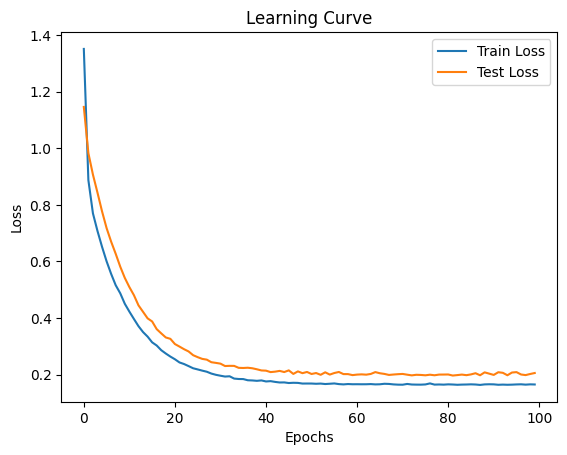

In [30]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Модель с одним слоем
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x)

# Инициализация модели
model_sgd = SimpleNN(X_train.shape[1])

# Определяем loss-функцию и оптимизатор
criterion = nn.MSELoss()  # Для регрессии используем MSELoss
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

# Тренировка модели с использованием SGD
epochs = 100
train_losses_sgd = []
test_losses_sgd = []

for epoch in range(epochs):
    model_sgd.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        optimizer_sgd.zero_grad()

        targets = targets.float()

        # Прямой проход
        outputs = model_sgd(inputs)

        # Вычисление ошибки
        loss = criterion(outputs.flatten(), targets)
        loss.backward()
        optimizer_sgd.step()

        epoch_train_loss += loss.item()

    train_losses_sgd.append(epoch_train_loss / len(train_loader))

    # Вычисляем loss на тестовой выборке
    model_sgd.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float()

            # Прямой проход
            outputs = model_sgd(inputs)
            loss = criterion(outputs.flatten(), targets)
            epoch_test_loss += loss.item()

    test_losses_sgd.append(epoch_test_loss / len(test_loader))

plt.plot(train_losses_sgd, label='Train Loss')
plt.plot(test_losses_sgd, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()


# Модель с 1 скрытым слоем и оптимизатором Adam





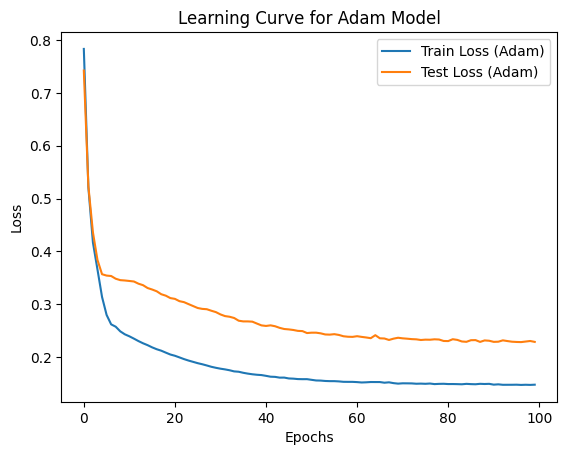

In [23]:
# Модель с одним скрытым слоем
class HiddenLayerNN(nn.Module):
    def __init__(self, input_dim):
        super(HiddenLayerNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)  # Скрытый слой
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)  # Выходной слой

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Инициализация модели
model_adam = HiddenLayerNN(X_train.shape[1])

# Определяем оптимизатор Adam
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

# Тренировка модели с использованием Adam
train_losses_adam = []
test_losses_adam = []

for epoch in range(epochs):
    model_adam.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        optimizer_adam.zero_grad()

        targets = targets.float()

        # Прямой проход
        outputs = model_adam(inputs)

        # Вычисление ошибки
        loss = criterion(outputs.flatten(), targets)
        loss.backward()
        optimizer_adam.step()

        epoch_train_loss += loss.item()

    train_losses_adam.append(epoch_train_loss / len(train_loader))

    # Вычисляем loss на тестовой выборке
    model_adam.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float()

            # Прямой проход
            outputs = model_adam(inputs)
            loss = criterion(outputs.flatten(), targets)
            epoch_test_loss += loss.item()

    test_losses_adam.append(epoch_test_loss / len(test_loader))

# Визуализация кривой обучения
plt.plot(train_losses_adam, label='Train Loss')
plt.plot(test_losses_adam, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()


# Модель с 3 скрытыми слоями и оптимизатором Adam


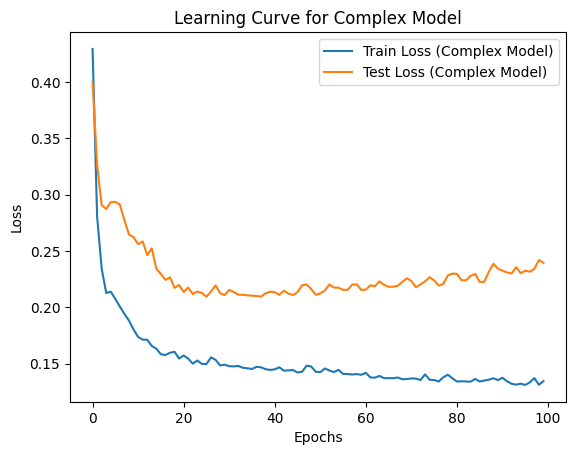

In [24]:
# Модель с тремя скрытыми слоями
class ComplexNN(nn.Module):
    def __init__(self, input_dim):
        super(ComplexNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

# Инициализация модели
model_complex = ComplexNN(X_train.shape[1])

# Определяем оптимизатор Adam
optimizer_complex = optim.Adam(model_complex.parameters(), lr=0.001)

# Тренировка модели с использованием Adam
train_losses_complex = []
test_losses_complex = []

for epoch in range(epochs):
    model_complex.train()
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        optimizer_complex.zero_grad()

        targets = targets.float()

        # Прямой проход
        outputs = model_complex(inputs)

        # Вычисление ошибки
        loss = criterion(outputs.flatten(), targets)
        loss.backward()
        optimizer_complex.step()

        epoch_train_loss += loss.item()

    train_losses_complex.append(epoch_train_loss / len(train_loader))

    # Вычисляем loss на тестовой выборке
    model_complex.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            targets = targets.float()

            # Прямой проход
            outputs = model_complex(inputs)
            loss = criterion(outputs.flatten(), targets)
            epoch_test_loss += loss.item()

    test_losses_complex.append(epoch_test_loss / len(test_loader))

# Визуализация кривой обучения
plt.plot(train_losses_complex, label='Train Loss')
plt.plot(test_losses_complex, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve')
plt.show()


# Оценка моделей (MAE, R^2)

In [25]:
from sklearn.metrics import mean_absolute_error, r2_score

# Получаем предсказания на тестовой выборке для всех моделей
def get_metrics(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, targets in loader:
            targets = targets.float()
            outputs = model(inputs)
            y_pred.append(outputs.flatten())
            y_true.append(targets)

    y_pred = torch.cat(y_pred).numpy()
    y_true = torch.cat(y_true).numpy()

    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mae, r2

# Метрики для моделей
mae_sgd, r2_sgd = get_metrics(model_sgd, test_loader)
mae_adam, r2_adam = get_metrics(model_adam, test_loader)
mae_complex, r2_complex = get_metrics(model_complex, test_loader)

print(f"SGD Model MAE: {mae_sgd}, R2: {r2_sgd}")
print(f"Adam Model MAE: {mae_adam}, R2: {r2_adam}")
print(f"Complex Model MAE: {mae_complex}, R2: {r2_complex}")


SGD Model MAE: 0.3524722456932068, R2: 0.24038910865783691
Adam Model MAE: 0.3512069284915924, R2: 0.18964862823486328
Complex Model MAE: 0.33914661407470703, R2: 0.16931742429733276
